# Minimum Viable Product

## Tree Classification Using Known Images


### MVP Overview

- **Goal:** To create a method to classify images (pictures) identifying types of trees. The client known as WeDontKnowTrees has a desire to start understanding the varieties of trees located in national parks so they can start identifying when a new tree species has appeared. On the flipside, they could also use it instead to identify endangered tree species without having to look in a book.

- **Solution Path:** The data chosen to being used is from the CIFAR-100 dataset located [here](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz). According to the University of Toronto description, this is the details:
  - data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 color image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in  row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  - labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

  This should give a good preliminary set to determine if finding trees with a neural network is possible as there are trees of different types in the dataset. A secondary set for more trees (specifically endangered) is still being researched.

- **Work Completed**: For pre-processing the data, I downloaded the cifar-100 dataset from the Keras dataset library. From there, I converted the classes to categorical binary class matrices, ensured the data was parsed as floats, created some initial metrics like shapes, and plotted 8 random images from the dataset. I then put each task into its own section which follows the lesson taught in [Introduction to Neural Networks](https://app.thisismetis.com/courses/222/pages/home-introduction-to-neural-networks). Following guidance from other write-ups with this dataset found in the references section, I add to a CNN model using Keras with a 3 stack model approach and made a model summary.

- **Recent Findings:** The model summary stated the existing model has 6,777,060 trainable parameters. However, the accuracy of the model is very low with a score of 0.0157. I did perform only one epoch though which most likely had a hand in that score. When the project is finished, I plan to have run the model approximately 200 epochs.

- **Moving Forward:** I will continue to research better images for trees, most likely from the [Google created datset Auto-Arborbist](https://google.github.io/auto-arborist/) which I am still waiting for approval from the dataset owner to download. I will also create a function to train the model for 200 epochs, and adjust the optimizers (Adam v. RMSProp v. SGD, etc.) to see if a better score can be met.

### Steps to Code a Neural Network

1. Build network structure
2. Complile the model (loss function, metrics, and optimizer)
3. Fit model on training data (batch size, number of epochs)
4. Make predictions for new data
5. Evaluate results

#### References
- https://app.thisismetis.com/courses/222/pages/chapter-10-keras?module_item_id=12549
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100/load_data
- https://www.kaggle.com/code/leokaka/cnn-66-acc-on-cifar100-without-transfer-learning
- https://github.com/keras-team/keras
- https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658
- https://olaralex.com/cnn-on-cifar100/
- https://github.com/chetnakhanna16/CIFAR100_ImageRecognition
- https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-convnet-for-cifar-10-and-cifar-100-classification-with-keras.md
- https://github.com/andrewkruger/cifar100_CNN
- https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100

### Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [2]:
pd.options.display.max_columns=100
pd.options.display.max_rows=100
pd.set_option('max_colwidth', 100)

### EDA

#### Load CIFAR-100 Dataset


In [3]:
# (input_train, target_train), (input_test, target_test) = cifar100.load_data()
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [4]:
# defione number of classes - cifar 100 has 100, so 100
num_classes = 100

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# parse numbers as floats which will speed up training
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data into the [latex][-1, 1][/latex] range
X_train /= 255.
X_test /= 255.

In [5]:
# shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"\ntrain samples: {X_train.shape[0]}")
print(f"test samples: {X_test.shape[0]}")

# input_shape = (img_width, img_height, img_num_channels)
print("\nimage shape:", X_train[0, :].shape)
# number of categories
print("number of categories:", to_categorical(y_train, num_classes).shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)

train samples: 50000
test samples: 10000

image shape: (32, 32, 3)
number of categories: (50000, 100, 100)


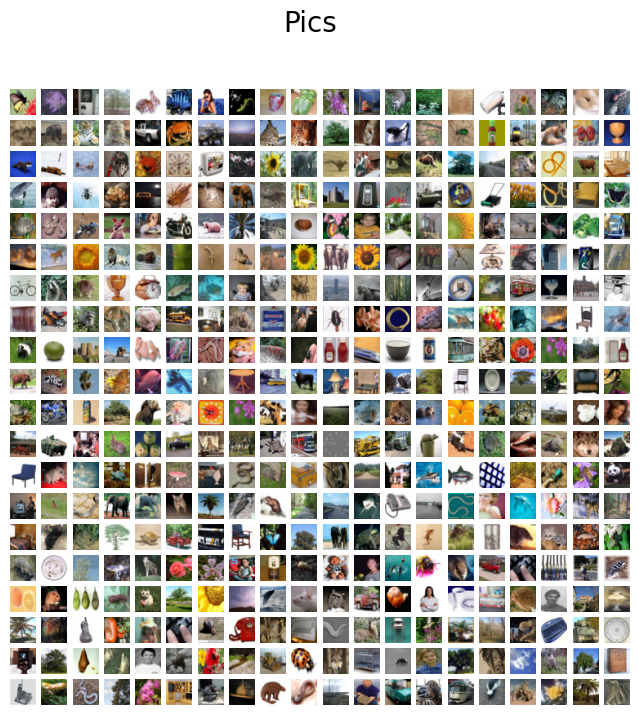

In [20]:
# set figure size
rcParams['figure.figsize'] = 8,8

# number of columns and rows in which images needs to be displayed
num_row = 20
num_col = 20

# to get 4 * 4 = 16 images together
pic_id = np.random.randint(0, len(X_train), num_row * num_col)

# create subplots
fig, axes = plt.subplots(num_row, num_col)

# title
plt.suptitle('Pics', fontsize=20)

# subplots
for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i * num_col) + j
        axes[i,j].imshow(X_train[pic_id[k]])
        # switch off x/y axis labels
        axes[i,j].axis('off')

### Build network structure

In [7]:
# using keras - CNN

model = Sequential()

# first stack - 2 convolutional layers with 128 units - using relu for now
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

# pooling - look at the grid (2x2) and use max only
# removes the number of parameters used and leaves most significant to prevent overfitting and reduces memory
model.add(MaxPooling2D(pool_size=(2, 2)))

# prevent overfitting by setting any fractional input rates at or below the dropout value to zero 
# removes neurons in the network leaving behind only neural connections with heavier weights
model.add(Dropout(0.1))

2022-10-22 17:08:51.385809: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-22 17:08:51.386677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# second stack - 2 convolutional layers with 256 units - using relu for now
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))

# second maxpool same as first
model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout becomes higher the higher in the stack to prevent overfitting
model.add(Dropout(0.2))

In [9]:
# third stack - 2 convolutional layers with 512 units - using relu for now
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))

# third maxpool same as first
model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout becomes higher the higher in the stack to prevent overfitting
model.add(Dropout(0.4))

In [10]:
# from the reference from Andrew Kruger, PhD as included in the reference section:
# The neural network ultimately needs to output the probability of the different classes in an array. 
# After the convolution stacks, the probabilities need to be flattened to a 1D feature vector. 
# The dense layers are fully-connected layers that apply transformations and change the dimensions. 
# The final dense layer needs to be the same length as the number of classes, and gives the probability of each class.

# post convolutional stacks
# flatten to a 1d vector
model.add(Flatten())

# add the dense layer - 1024 units (doubled from last stack) - using elu for now
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))

# add the final dense layer - num_classes is set to 100 as the cifar100 has 100 classes
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [11]:
# show summary stats
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 256)       2

### Compile the model

In [14]:
# initiate optimizer choice and train

#opt = RMSprop(lr=0.001, momentum=0.5)
opt = Adam(lr=0.001)
#opt = SGD(lr=0.001, momentum=0.5)

model.compile(loss='categorical_crossentropy',
                optimizer=opt, 
                metrics=['accuracy'])

### Fit the model to training data

In [15]:
model.fit(X_train, y_train, batch_size=128)

2022-10-22 17:24:34.650213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


391/391 [==============================] - 426s 1s/step - loss: 4.4480 - accuracy: 0.0250


### Make predictions for new data

In [17]:
classes = model.predict(X_test, batch_size=128)

In [18]:
classes

array([[8.1830320e-04, 6.2387753e-03, 3.3812574e-03, ..., 6.7286002e-03,
        2.7590815e-03, 3.0577693e-02],
       [1.1351272e-03, 3.7019316e-03, 8.0830595e-03, ..., 4.0390156e-02,
        7.4219187e-03, 1.5218050e-02],
       [7.5342669e-03, 1.7116351e-02, 8.1644179e-03, ..., 3.2898609e-03,
        9.7361505e-03, 3.6143684e-03],
       ...,
       [2.3325414e-03, 1.2001580e-02, 1.3242492e-03, ..., 6.0642627e-03,
        3.3274589e-03, 5.0875684e-03],
       [1.6451241e-03, 2.0638444e-03, 1.0415141e-02, ..., 2.7732674e-02,
        9.6061425e-03, 9.9959904e-03],
       [1.3582212e-01, 1.3218363e-02, 8.0545200e-03, ..., 9.4965668e-05,
        1.4995965e-02, 2.7394237e-03]], dtype=float32)

### Evaluate results

In [16]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 15s 184ms/step - loss: 3.8473 - accuracy: 0.1030


In [19]:
loss_and_metrics

[3.847332715988159, 0.10300000011920929]